### Basic QNN Training

This notebook trains a simple hybrid quantum classical neural network and stores the
result on disk.

In [1]:
# Imports
import pennylane as qml
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt

In [2]:
# Set keras float type
tf.keras.backend.set_floatx('float64')

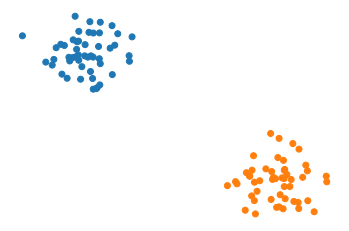

In [3]:
# Generate random data
np.random.seed(42)
tf.random.set_seed(42)

x, y = make_blobs(n_samples=100, n_features=2, centers=2)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()


In [4]:
# Configure Device
n_qubits = 1

local = True
remote_device = None
%store -r remote_device

if local:
    # Local simulator
    dev = qml.device("default.qubit", wires=n_qubits)
elif remote_device:
    dev = remote_device
else:
    # Connect to IBMQ Device
    with open('../config/token.txt', 'r') as file:
        token = file.read()

    remote_device = qml.device(
        'qiskit.ibmq', wires=1,
        backend='ibmq_armonk', ibmqx_token=token)

    %store remote_device
    dev = remote_device

In [5]:
# Define a QNode for a quantum layer with 1 qubit
tasks_executed = 0

@qml.qnode(dev)
def qnode(inputs, weights):
    global tasks_executed
    tasks_executed += 1

    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [6]:
# Convert QNode to keras layer
n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [7]:
# Define classical layers
clayer_1 = tf.keras.layers.Dense(1)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")

In [8]:
# Train hybrid neural network
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])
fitting = model.fit(x[:,0], y_hot, epochs=2, batch_size=5, validation_split=0.5, verbose=2)

Epoch 1/2
10/10 - 1s - loss: 0.5010 - accuracy: 0.5000 - val_loss: 0.4671 - val_accuracy: 0.8600
Epoch 2/2
10/10 - 1s - loss: 0.3998 - accuracy: 0.9800 - val_loss: 0.3018 - val_accuracy: 1.0000


In [9]:
print("Tasks executed:", tasks_executed)

Tasks executed: 200


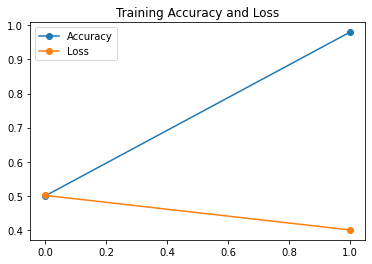

In [10]:
plt.plot(fitting.history['accuracy'], "-o", label='Accuracy')
plt.plot(fitting.history['loss'], "-o", label='Loss')
plt.legend(loc='best')
plt.title('Training Accuracy and Loss')
plt.show()

In [11]:
# Save weights of model
model.save_weights("../output/primitive_model.tf", save_format="tf")
print("Model saved successfully!")

Model saved successfully!
